In [1]:
import warnings
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import plot_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import re
import unicodedata

In [3]:
print(f"Tensor Flow Version: {tf.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "AVAILABLE" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.12.0

GPU is AVAILABLE


In [4]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /usr/share/nltk_data...
[nltk_data]    | Downloading pa

True

In [5]:
dt = pd.read_csv(r"/kaggle/input/language-translation-englishfrench/eng_-french.csv")
dt.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


## data management

1.shuffle the data
dt = dt.sample(frac=1).reset_index(drop=True)

2.split the data into train, validation, and test sets
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.2)
test_size = int(len(df) * 0.1)

train_df = df[:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

3.display the data sets representations using a pie chart just to see the distribution of the data
labels = 'Train', 'Validation', 'Test'
sizes = [len(train_df), len(val_df), len(test_df)]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

In [6]:
dt = dt.sample(frac = 1).reset_index(drop = True)

In [7]:
dt.head()

,English words/sentences,French words/sentences
0,Did you see the sunrise earlier? It was really...,As-tu vu le lever de soleil tout à l'heure ? C...
1,Tom set the bird free.,Tom libéra l'oiseau.
2,That patient may die at any time.,Ce patient peut mourir à tout moment.
3,You're funny.,T'es marrante.
4,I guess you heard about what happened this mor...,Je suppose que vous avez ouï dire ce qui s'est...


In [8]:
dt.rename(columns = {'English words/sentences':'Eng', 'French words/sentences':'French'}, inplace = True)
dt.head()

,Eng,French
0,Did you see the sunrise earlier? It was really...,As-tu vu le lever de soleil tout à l'heure ? C...
1,Tom set the bird free.,Tom libéra l'oiseau.
2,That patient may die at any time.,Ce patient peut mourir à tout moment.
3,You're funny.,T'es marrante.
4,I guess you heard about what happened this mor...,Je suppose que vous avez ouï dire ce qui s'est...


In [9]:
df = dt.copy()

In [10]:
data = df[:100000]
data

,Eng,French
0,Did you see the sunrise earlier? It was really...,As-tu vu le lever de soleil tout à l'heure ? C...
1,Tom set the bird free.,Tom libéra l'oiseau.
2,That patient may die at any time.,Ce patient peut mourir à tout moment.
3,You're funny.,T'es marrante.
4,I guess you heard about what happened this mor...,Je suppose que vous avez ouï dire ce qui s'est...
...,...,...
99995,I thought that you were able to speak French.,Je pensais que tu étais capable de parler fran...
99996,I am too tired to climb.,Je suis trop fatigué pour grimper.
99997,My colleague doctored the report.,Mon collègue a trafiqué le rapport.
99998,Do you want to grab dinner?,Veux-tu prendre à déjeuner ?


In [11]:
data['French'] = data['French'].apply(lambda x: '<SOS> ' + x + ' <EOS>')

/tmp/ipykernel_26/41751442.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['French'] = data['French'].apply(lambda x: '<SOS> ' + x + ' <EOS>')


In [12]:
data.head()

,Eng,French
0,Did you see the sunrise earlier? It was really...,<SOS> As-tu vu le lever de soleil tout à l'heu...
1,Tom set the bird free.,<SOS> Tom libéra l'oiseau. <EOS>
2,That patient may die at any time.,<SOS> Ce patient peut mourir à tout moment. <EOS>
3,You're funny.,<SOS> T'es marrante. <EOS>
4,I guess you heard about what happened this mor...,<SOS> Je suppose que vous avez ouï dire ce qui...


In [13]:
# Unicode normalization
def normalize_unicode(s):
    return ''.join( c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn')

In [14]:
def eng_preprocessing(text):
    text = text.lower()
    text = re.sub(re.compile('https?://\S+|www\.\S+|\d+|<.*?>'), '', text)
    text = nltk.word_tokenize(text)
    text = " ".join([i.strip() for i in text])
    return text



def french_preprocessing(texts):
    texts = normalize_unicode(texts)
    texts = texts.lower()
    texts = re.sub(re.compile("[^a-zéâàçêêëôîû!?',]"), ' ', texts)
    return texts

In [15]:
data['Eng'] = data['Eng'].apply(lambda x: eng_preprocessing(x))
data['French'] = data['French'].apply(lambda x: french_preprocessing(x))

/tmp/ipykernel_26/1460006921.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Eng'] = data['Eng'].apply(lambda x: eng_preprocessing(x))
/tmp/ipykernel_26/1460006921.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['French'] = data['French'].apply(lambda x: french_preprocessing(x))


In [16]:
data.head()

,Eng,French
0,did you see the sunrise earlier ? it was reall...,sos as tu vu le lever de soleil tout a l'heu...
1,tom set the bird free .,sos tom libera l'oiseau eos
2,that patient may die at any time .,sos ce patient peut mourir a tout moment eos
3,you 're funny .,sos t'es marrante eos
4,i guess you heard about what happened this mor...,sos je suppose que vous avez oui dire ce qui...


In [17]:
def source_vectorization(text):
    eng_token = Tokenizer()
    eng_token.fit_on_texts(text)
    eng_seq = eng_token.texts_to_sequences(text)
    eng_padded = pad_sequences(eng_seq, padding = 'post')
    return eng_padded, eng_token

def target_vectorization(text):
    french_token = Tokenizer()
    french_token.fit_on_texts(text)
    french_seq = french_token.texts_to_sequences(text)
    french_padded = pad_sequences(french_seq, padding = 'post')
    return french_padded, french_token

In [18]:
eng_padded, eng_token = source_vectorization(data['Eng'])

In [19]:
eng_padded.shape

(100000, 47)

In [20]:
eng_vocab = len(eng_token.word_index) + 1
eng_vocab

11625

In [21]:
french_padded, french_token = target_vectorization(data['French'])

In [22]:
french_padded.shape

(100000, 57)

In [23]:
french_vocab = len(french_token.word_index) + 1
french_vocab

20757

In [24]:
eng_seq_len = eng_padded.shape[1]
french_seq_len = french_padded.shape[1]
dec_inp_seq_len = french_seq_len - 1 
embed_dim = 100
eng_vocab = eng_vocab
french_vocab = french_vocab
batch_size = 100000
num_heads = 5
head_dim = embed_dim//num_heads
hidden_dim = 64
num_blocks = 2

**Things to be Done Here...**

1. Positional Embeddings
2. Masking for Encoders
3. Masking + Look ahead masking for decoders
4. Encoder Block
5. Encoder
6. Decoder Block
7. Decoder
8. Transformer

In [25]:
class positional_encoding(tf.keras.layers.Layer):
    
    def __init__(self, voc_size, sequence_length, embedding_dim, **kwargs):
        super().__init__(**kwargs)

        self.voc_size = voc_size
        self.sequence_length = sequence_length
        self.embedding_dim = embedding_dim

        self.embedding_layer = tf.keras.layers.Embedding(input_dim=self.voc_size, output_dim=self.embedding_dim, input_length=self.sequence_length)
        self.positional_encoding = tf.keras.layers.Embedding(self.sequence_length, self.embedding_dim)


    def call(self, inputs):

        pos_ids = tf.range(self.sequence_length)
        token_embed = self.embedding_layer(inputs)
        token_positional = self.positional_encoding(pos_ids)
        final = token_embed + token_positional
        return  final

In [26]:
class padding_mask(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):

        mask = tf.cast(tf.math.not_equal(inputs, 0), tf.float32)
        mask = mask[:, tf.newaxis, :]

        return mask

In [27]:
class look_ahead_masking(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.masking = padding_mask()

    def call(self, inputs, sequence_length):
        masked = self.masking(inputs)
        look = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
        dec_mask = tf.minimum(masked,look)

        return dec_mask

In [28]:
class encoder_layer(tf.keras.layers.Layer):

    def __init__(self, num_heads, embedding_dim, hidden_dim, dropout_rate = 0.1, **kwargs):
        super().__init__()

        self.num_heads = num_heads
        self.embedding_dim = embedding_dim

        self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads=self.num_heads, key_dim = self.embedding_dim, dropout = dropout_rate)

        self.ffn = tf.keras.Sequential([tf.keras.layers.Dense(hidden_dim, activation = 'relu'), tf.keras.layers.Dense(embedding_dim, activation='relu')])

        self.drop1 = tf.keras.layers.Dropout(dropout_rate)
        self.drop2 = tf.keras.layers.Dropout(dropout_rate)

        self.norm1 = tf.keras.layers.LayerNormalization()
        self.norm2 = tf.keras.layers.LayerNormalization()

        self.add = tf.keras.layers.Add()

    def call(self, enc_inputs, enc_mask, training):

        mha_out1 = self.mha1(enc_inputs, enc_inputs, enc_inputs, enc_mask)
        drop_out1 = self.drop1(mha_out1, training = training)
        norm_out1 = self.norm1(self.add([drop_out1,enc_inputs]))

        ffn_out = self.ffn(norm_out1)
        drop_out2 = self.drop2(ffn_out, training = training)
        norm_out2 = self.norm2(self.add([drop_out2, norm_out1]))

        return norm_out2

In [29]:
class Encoder(tf.keras.layers.Layer):
    
    def __init__(self, num_heads, num_blocks, voc_size, sequence_length, embedding_dim, hidden_dim, dropout_rate = 0.1, **kwargs):
        super().__init__(**kwargs)

        self.pos_embedded = positional_encoding(voc_size, sequence_length, embedding_dim)
        self.pad = padding_mask()

        self.add = tf.keras.layers.Add()
        self.encoder = [encoder_layer(num_heads, embedding_dim, hidden_dim) for i in range(num_blocks)]


    def call(self, enc_inputs, training):
        emb = self.pos_embedded(enc_inputs)
        skip = emb
        mask = self.pad(enc_inputs)

        for layer in self.encoder:
            emb = layer(emb, mask, training)
            emb = self.add([skip,emb])
            skip = emb

        return emb, mask

In [30]:
class decoder_layer(tf.keras.layers.Layer):

    def __init__(self, num_heads, embedding_dim, hidden_dim, dropout_rate = 0.1, **kwargs):
        super().__init__()

        self.num_heads = num_heads
        self.embedding_dim = embedding_dim

        self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads=self.num_heads, key_dim = self.embedding_dim, dropout = dropout_rate)
        self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads=self.num_heads, key_dim = self.embedding_dim, dropout = dropout_rate)

        self.ffn = tf.keras.Sequential([tf.keras.layers.Dense(hidden_dim, activation = 'relu'), tf.keras.layers.Dense(embedding_dim, activation='relu')])

        self.drop1 = tf.keras.layers.Dropout(dropout_rate)
        self.drop2 = tf.keras.layers.Dropout(dropout_rate)
        self.drop3 = tf.keras.layers.Dropout(dropout_rate)

        self.norm1 = tf.keras.layers.LayerNormalization()
        self.norm2 = tf.keras.layers.LayerNormalization()
        self.norm3 = tf.keras.layers.LayerNormalization()

        self.add = tf.keras.layers.Add()

    def call(self, dec_inputs, enc_outputs, enc_mask, dec_mask, training):

        mha_out1 = self.mha1(dec_inputs, dec_inputs, dec_inputs, dec_mask)
        drop_out1 = self.drop1(mha_out1, training = training)
        norm_out1 = self.norm1(self.add([drop_out1,dec_inputs]))

        mha_out2 = self.mha2(norm_out1, enc_outputs, enc_outputs, enc_mask)
        drop_out2 = self.drop2(mha_out1, training = training)
        norm_out2 = self.norm2(self.add([drop_out2,norm_out1]))

        ffn_out = self.ffn(norm_out2)
        drop_out3 = self.drop3(ffn_out, training = training)
        norm_out3 = self.norm3(self.add([drop_out3, norm_out2]))

        return norm_out3

In [31]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self, num_heads, num_blocks, voc_size, sequence_length, embedding_dim, hidden_dim, dropout_rate = 0.1, **kwargs):
        super().__init__(**kwargs)

        self.sequence_length = sequence_length
        self.pos_embedded = positional_encoding(voc_size, sequence_length, embedding_dim)
        self.pad = padding_mask()
        self.look_ahead = look_ahead_masking()
        self.add = tf.keras.layers.Add()
        self.decoder = [decoder_layer(num_heads, embedding_dim, hidden_dim) for i in range(num_blocks)]


    def call(self, dec_inputs, enc_outputs, enc_mask, training):

        res = self.pos_embedded(dec_inputs)
        look_ahead = self.look_ahead(dec_inputs, self.sequence_length)
        temp = res

        for layer in self.decoder:
            res = layer(res, enc_outputs, enc_mask, look_ahead, training)
            res = self.add([temp,res])
            temp = res

        return res

In [32]:
class Transformer(tf.keras.Model):

    def __init__(self, num_heads, num_blocks, eng_voc_size, french_voc_size, eng_sequence_length, dec_input_sequence_length, embedding_dim, hidden_dim, dropout_rate = 0.1, **kwargs):
        super().__init__(**kwargs)

        self.encoder = Encoder(num_heads, num_blocks, eng_voc_size, eng_sequence_length, embedding_dim, hidden_dim)
        self.decoder = Decoder(num_heads, num_blocks, french_voc_size, dec_input_sequence_length, embedding_dim, hidden_dim)

        self.Final_layer = tf.keras.layers.Dense(french_voc_size, activation='relu')
        self.softmax = tf.keras.layers.Softmax(axis=-1)


    def call(self, inputs):
        enc_inp, dec_inp = inputs

        enc_out, enc_mask = self.encoder(enc_inp)
        dec_out = self.decoder(dec_inp, enc_out, enc_mask)

        final_out = self.Final_layer(dec_out)
        softmax_out = self.softmax(final_out)

        return softmax_out


In [33]:
trans = Transformer(num_heads, num_blocks, eng_vocab, french_vocab, eng_seq_len, dec_inp_seq_len, embed_dim, hidden_dim)

In [34]:
transformed = trans((eng_padded[:1], french_padded[:1,:-1]))

In [35]:
trans.get_build_config()

{'input_shape': ((1, 47), (1, 56))}

In [36]:
trans.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  1597128   
                                                                 
 decoder (Decoder)           multiple                  2914828   
                                                                 
 dense_8 (Dense)             multiple                  2096457   
                                                                 
 softmax (Softmax)           multiple                  0         
                                                                 
Total params: 6,608,413
Trainable params: 6,608,413
Non-trainable params: 0
_________________________________________________________________


In [37]:
compilation = trans.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),metrics=["accuracy"])

In [38]:
calls = tf.keras.callbacks.EarlyStopping(patience = 5, verbose = True)

In [39]:
dataset = tf.data.Dataset.from_tensor_slices(((eng_padded,french_padded[:,:-1]), french_padded[:,1:]))

In [40]:
fitting = trans.fit((eng_padded,french_padded[:,:-1]), french_padded[:, 1:], validation_split=0.20 ,epochs = 100, batch_size = 500, verbose = True, callbacks = calls)

Epoch 1/100
160/160 [==============================] - 111s 628ms/step - loss: 2.1254 - accuracy: 0.8641 - val_loss: 0.7054 - val_accuracy: 0.8955
Epoch 2/100
160/160 [==============================] - 92s 574ms/step - loss: 0.6518 - accuracy: 0.8988 - val_loss: 0.6271 - val_accuracy: 0.9008
Epoch 3/100
160/160 [==============================] - 90s 566ms/step - loss: 0.5998 - accuracy: 0.9024 - val_loss: 0.6031 - val_accuracy: 0.9025
Epoch 4/100
160/160 [==============================] - 89s 557ms/step - loss: 0.5724 - accuracy: 0.9047 - val_loss: 0.5910 - val_accuracy: 0.9034
Epoch 5/100
160/160 [==============================] - 89s 557ms/step - loss: 0.5531 - accuracy: 0.9064 - val_loss: 0.5827 - val_accuracy: 0.9044
Epoch 6/100
160/160 [==============================] - 88s 552ms/step - loss: 0.5376 - accuracy: 0.9079 - val_loss: 0.5773 - val_accuracy: 0.9053
Epoch 7/100
160/160 [==============================] - 88s 553ms/step - loss: 0.5246 - accuracy: 0.9093 - val_loss: 0.5735 

In [41]:
fitting.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

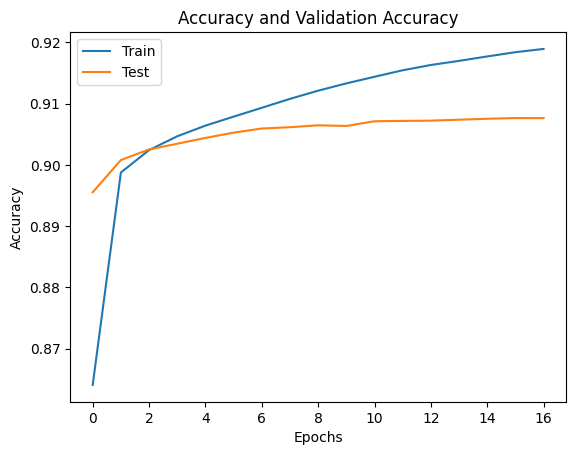

In [42]:
plt.plot(fitting.history['accuracy'])
plt.plot(fitting.history['val_accuracy'])
plt.title('Accuracy and Validation Accuracy')
plt.legend(['Train', 'Test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

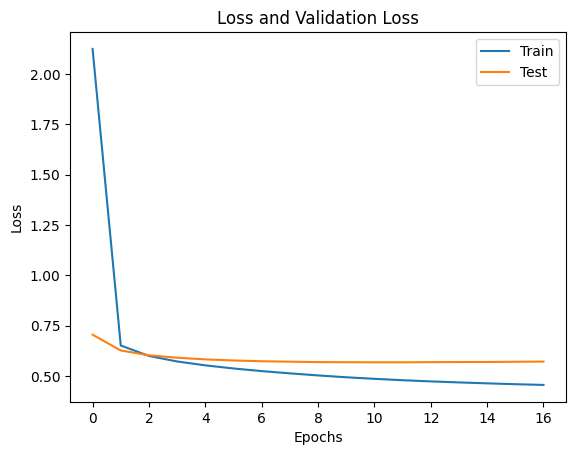

In [43]:
plt.plot(fitting.history['loss'])
plt.plot(fitting.history['val_loss'])
plt.title('Loss and Validation Loss')
plt.legend(['Train', 'Test'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Wrapping Up